In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
ratings_list = [i.strip().split("::") for i in open('ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('movies.dat', 'r',encoding='latin-1').readlines()]

ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
user_df=pd.DataFrame(users_list, columns=['UserID','Gender','Age','Occupation','ZipCode'])

In [4]:
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
user_df['UserID'] = user_df['UserID'].apply(pd.to_numeric)
user_df['Age'] = user_df['Age'].apply(pd.to_numeric)

In [5]:
print("User table description:")
print(user_df.head())
print(user_df.describe())

User table description:
   UserID Gender  Age Occupation ZipCode
0       1      F    1         10   48067
1       2      M   56         16   70072
2       3      M   25         15   55117
3       4      M   45          7   02460
4       5      M   25         20   55455
            UserID          Age
count  6040.000000  6040.000000
mean   3020.500000    30.639238
std    1743.742145    12.895962
min       1.000000     1.000000
25%    1510.750000    25.000000
50%    3020.500000    25.000000
75%    4530.250000    35.000000
max    6040.000000    56.000000


In [6]:
print("Rating table description:")
print(ratings_df.head())
print(ratings_df.describe())

Rating table description:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
             UserID       MovieID        Rating     Timestamp
count  1.000209e+06  1.000209e+06  1.000209e+06  1.000209e+06
mean   3.024512e+03  1.865540e+03  3.581564e+00  9.722437e+08
std    1.728413e+03  1.096041e+03  1.117102e+00  1.215256e+07
min    1.000000e+00  1.000000e+00  1.000000e+00  9.567039e+08
25%    1.506000e+03  1.030000e+03  3.000000e+00  9.653026e+08
50%    3.070000e+03  1.835000e+03  4.000000e+00  9.730180e+08
75%    4.476000e+03  2.770000e+03  4.000000e+00  9.752209e+08
max    6.040000e+03  3.952000e+03  5.000000e+00  1.046455e+09


In [7]:
print("Movies table description:")
print(movies_df.head())
print(movies_df.describe())

Movies table description:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
           MovieID
count  3883.000000
mean   1986.049446
std    1146.778349
min       1.000000
25%     982.500000
50%    2010.000000
75%    2980.500000
max    3952.000000


In [8]:
print("Top Five most rated movies:")
print(ratings_df['MovieID'].value_counts().head())

Top Five most rated movies:
2858    3428
260     2991
1196    2990
1210    2883
480     2672
Name: MovieID, dtype: int64


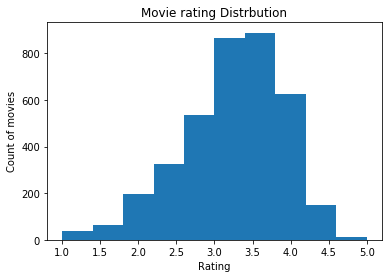

In [9]:
plt.hist(ratings_df.groupby(['MovieID'])['Rating'].mean().sort_values(axis=0, ascending=False))
plt.title("Movie rating Distrbution")
plt.ylabel('Count of movies')
plt.xlabel('Rating');
plt.show()

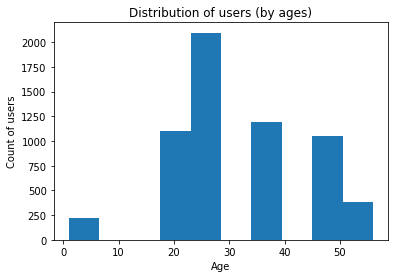

In [10]:
user_df.Age.plot.hist()
plt.title("Distribution of users (by ages)")
plt.ylabel('Count of users')
plt.xlabel('Age');
plt.show()

In [11]:
movie_ratings = pd.merge(movies_df, ratings_df)
df=pd.merge(movie_ratings,user_df)
movie_stats = df.groupby('Title').agg({'Rating': [np.size, np.mean]})

print("Highest rated moview with minimum 150 ratings")
print(movie_stats.Rating[movie_stats.Rating['size'] > 150].sort_values(['mean'],ascending=[0]).head())

Highest rated moview with minimum 150 ratings
                                                    size      mean
Title                                                             
Seven Samurai (The Magnificent Seven) (Shichini...   628  4.560510
Shawshank Redemption, The (1994)                    2227  4.554558
Godfather, The (1972)                               2223  4.524966
Close Shave, A (1995)                                657  4.520548
Usual Suspects, The (1995)                          1783  4.517106


In [12]:
pivoted = df.pivot_table(index=['MovieID', 'Title'],
                           columns=['Gender'],
                           values='Rating',
                           fill_value=0)

print("Gender biasing towards movie rating")
print(pivoted.head())

Gender biasing towards movie rating
Gender                                             F         M
MovieID Title                                                 
1       Toy Story (1995)                    4.187817  4.130552
2       Jumanji (1995)                      3.278409  3.175238
3       Grumpier Old Men (1995)             3.073529  2.994152
4       Waiting to Exhale (1995)            2.976471  2.482353
5       Father of the Bride Part II (1995)  3.212963  2.888298


In [13]:
pivoted['diff'] = pivoted.M - pivoted.F
print(pivoted.head())

Gender                                             F         M      diff
MovieID Title                                                           
1       Toy Story (1995)                    4.187817  4.130552 -0.057265
2       Jumanji (1995)                      3.278409  3.175238 -0.103171
3       Grumpier Old Men (1995)             3.073529  2.994152 -0.079377
4       Waiting to Exhale (1995)            2.976471  2.482353 -0.494118
5       Father of the Bride Part II (1995)  3.212963  2.888298 -0.324665


Implementing a movie recommendation engine

In [14]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
np.random.seed(2017)

def read_file(filname, sep="\t"):
    col_names = ["user", "item", "rate", "st"]
    df = pd.read_csv(filname, sep=sep, header=None, names=col_names, engine='python')
    df["user"] -= 1
    df["item"] -= 1
    for col in ("user", "item"):
        df[col] = df[col].astype(np.int32)
    df["rate"] = df["rate"].astype(np.float32)
    return df

class ShuffleIterator(object):
    """
    Randomly generate batches
    """
    def __init__(self, inputs, batch_size=10):
        self.inputs = inputs
        self.batch_size = batch_size
        self.num_cols = len(self.inputs)
        self.len = len(self.inputs[0])
        self.inputs = np.transpose(np.vstack([np.array(self.inputs[i]) for i in range(self.num_cols)]))

    def __len__(self):
        return self.len

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        ids = np.random.randint(0, self.len, (self.batch_size,))
        out = self.inputs[ids, :]
        return [out[:, i] for i in range(self.num_cols)]

class OneEpochIterator(ShuffleIterator):
    """
    Sequentially generate one-epoch batches, typically for test data
    """
    def __init__(self, inputs, batch_size=10):
        super(OneEpochIterator, self).__init__(inputs, batch_size=batch_size)
        if batch_size > 0:
            self.idx_group = np.array_split(np.arange(self.len), np.ceil(self.len / batch_size))
        else:
            self.idx_group = [np.arange(self.len)]
        self.group_id = 0

    def next(self):
        if self.group_id >= len(self.idx_group):
            self.group_id = 0
            raise StopIteration
        out = self.inputs[self.idx_group[self.group_id], :]
        self.group_id += 1
        return [out[:, i] for i in range(self.num_cols)]

In [15]:
from collections import deque
from six import next
import readers
import os

import numpy as np
import pandas as pd

import time

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from tensorflow.python.framework import ops
import warnings
import random
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ops.reset_default_graph()

In [16]:
np.random.seed(12345)

In [17]:
# Data Parameters
data_file = "C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/data/ratings.dat" #Input user-movie-rating information file

# Eval Parameters
batch_size =  1000 # Batch Size 
dims = 15 # Dimensions of SVD (default: 15)
max_epochs = 50 # Max epoch of SVD (default: 25)
checkpoint_dir = "C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/save/" # Checkpoint directory from training run
val = True # True if Folders with files and False if single file
is_gpu = False # Want to train model with GPU

# Misc Parameters
allow_soft_placement = True # Allow device soft device placement
log_device_placement = True # Log placement of ops on devices

In [18]:
print("Start removing previous Files ...")
if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table.pkl"):
    os.remove("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table.pkl")
if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table_train.pkl"):
    os.remove("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table_train.pkl")
if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/item_item_corr.pkl"):
    os.remove("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/item_item_corr.pkl")
if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive AnalyticsPredictive Analytics/Section 10/model/item_item_corr_train.pkl"):
    os.remove("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/item_item_corr_train.pkl")
if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_user_corr.pkl"):
    os.remove("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_user_corr.pkl")
if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_user_corr_train.pkl"):
    os.remove("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_user_corr_train.pkl")
if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/clusters.csv"):
    os.remove("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/clusters.csv")
if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/val_error.pkl"):
    os.remove("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/val_error.pkl")
print("Done ...")

Start removing previous Files ...
Done ...


In [19]:
checkpoint_prefix = os.path.join(checkpoint_dir, "model")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [20]:
batch_size = batch_size   
dims = dims               
max_epochs = max_epochs

In [21]:
if is_gpu:
    place_device = "/gpu:0"
else:
    place_device="/cpu:0"

In [22]:
def get_data():
    # Reads file using the demiliter :: form the ratings file
    # Download movie lens data from: http://files.grouplens.org/datasets/movielens/ml-1m.zip
    # Columns are user ID, item ID, rating, and timestamp
    # Sample data - 3::1196::4::978297539
    print("Inside get data ...")
    df = readers.read_file(data_file, sep="::")
    rows = len(df)

    # Purely integer-location based indexing for selection by position
    df = df.iloc[np.random.permutation(rows)].reset_index(drop=True)

    # Split data into train and test, 75% for train and 25% for test
    split_index = int(rows * 0.75)

    # Use indices to separate the data
    df_train = df[0:split_index]
    df_test = df[split_index:].reset_index(drop=True)

    print("Done !!!")
    print(df.shape)
    return df_train, df_test,df['user'].max(),df['item'].max()

# Clip (limit) the values in an array: given an interval, values outside the interval are clipped to the interval edges. 
#For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.
def clip(x):
    return np.clip(x, 1.0, 5.0) # rating 1 to 5

# Read data from ratings file to build a TF model
df_train, df_test,u_num,i_num = get_data()

print(u_num)
print(i_num)
u_num = 6040 # Number of users in the dataset
i_num = 3952 # Number of movies in the dataset


samples_per_batch = len(df_train) // batch_size
print("Number of train samples %d, test samples %d, samples per batch %d" % (len(df_train), len(df_test), samples_per_batch))

# Using a shuffle iterator to generate random batches, for training this helps preventing biased result
iter_train = readers.ShuffleIterator([df_train["user"],
                                     df_train["item"],
                                     df_train["rate"]],
                                     batch_size=batch_size)

# Sequentially generate one-epoch batches, for testing
iter_test = readers.OneEpochIterator([df_test["user"],
                                     df_test["item"],
                                     df_test["rate"]],
                                     batch_size=-1)

Inside get data ...
Done !!!
(1000209, 4)
6039
3951
Number of train samples 750156, test samples 250053, samples per batch 750


In [23]:
def model(user_batch, item_batch, user_num, item_num, dim=5, device="/cpu:0"):
    with tf.device("/cpu:0"):
        # Using a global bias term
        bias_global = tf.get_variable("bias_global", shape=[])
        # User and item bias variables get_variable: Prefixes the name 
        # with the current variable scope and performs reuse checks.

        w_bias_user = tf.get_variable("embd_bias_user", shape=[user_num])
        w_bias_item = tf.get_variable("embd_bias_item", shape=[item_num])

        # embedding_lookup: Looks up 'ids' in a list of embedding tensors
        # Bias embeddings for user and items, given a batch
        bias_user = tf.nn.embedding_lookup(w_bias_user, user_batch, name="bias_user")
        bias_item = tf.nn.embedding_lookup(w_bias_item, item_batch, name="bias_item")

        # User and item weight variables
        w_user = tf.get_variable("embd_user", shape=[user_num, dim],
                                 initializer=tf.truncated_normal_initializer(stddev=0.02))
        w_item = tf.get_variable("embd_item", shape=[item_num, dim],
                                 initializer=tf.truncated_normal_initializer(stddev=0.02))
                                 
        # Weight embeddings for user and items, given a batch
        embd_user = tf.nn.embedding_lookup(w_user, user_batch, name="embedding_user")
        embd_item = tf.nn.embedding_lookup(w_item, item_batch, name="embedding_item")

        # reduce_sum: Computes the sum of elements across dimensions of a tensor
        infer = tf.reduce_sum(tf.multiply(embd_user, embd_item), 1)
        infer = tf.add(infer, bias_global)
        infer = tf.add(infer, bias_user)
        infer = tf.add(infer, bias_item, name="svd_inference")
        # l2_loss: Computes half the L2 norm of a tensor without the sqrt
        regularizer = tf.add(tf.nn.l2_loss(embd_user), tf.nn.l2_loss(embd_item), name="svd_regularizer")
    return infer, regularizer

In [24]:
def loss(infer, regularizer, rate_batch, learning_rate=0.1, reg=0.1, device="/cpu:0"):
    with tf.device(device):
        cost_l2 = tf.nn.l2_loss(tf.subtract(infer, rate_batch))
        penalty = tf.constant(reg, dtype=tf.float32, shape=[], name="l2")
        cost = tf.add(cost_l2, tf.multiply(regularizer, penalty))
        train_op = tf.train.FtrlOptimizer(learning_rate).minimize(cost)
    return cost, train_op

In [25]:
user_batch = tf.placeholder(tf.int32, shape = [None], name = "id_user")
item_batch = tf.placeholder(tf.int32, shape = [None], name = "id_item")
rate_batch = tf.placeholder(tf.float32, shape = [None])

In [26]:
infer, regularizer = model(user_batch, item_batch, user_num = u_num, item_num = i_num, dim = dims, device = place_device)
_, train_op = loss(infer, regularizer, rate_batch, learning_rate = 0.001, reg = 0.05, device = place_device)

In [27]:
saver = tf.train.Saver()
init_op = tf.global_variables_initializer()
session_conf = tf.ConfigProto(allow_soft_placement=allow_soft_placement, log_device_placement=log_device_placement)

In [29]:
with tf.Session(config = session_conf) as sess:
    sess.run(init_op)
    print("%s\t%s\t%s\t%s" % ("Epoch", "Train err", "Validation err", "Elapsed Time"))
    errors = deque(maxlen = samples_per_batch)
    train_error  =[]
    val_error = []
    start = time.time()
    for i in range(max_epochs * samples_per_batch):
        users, items, rates = next(iter_train)
        _, pred_batch = sess.run([train_op, infer], feed_dict = {user_batch: users, item_batch: items, rate_batch: rates})
        pred_batch = clip(pred_batch)
        errors.append(np.power(pred_batch - rates, 2))
        if i % samples_per_batch == 0:
            train_err = np.sqrt(np.mean(errors))
            test_err2 = np.array([])
            for users, items, rates in iter_test:
                pred_batch = sess.run(infer, feed_dict={user_batch: users, item_batch: items})
                pred_batch = clip(pred_batch)
                test_err2 = np.append(test_err2, np.power(pred_batch - rates, 2))
            end = time.time()

            print("%02d\t%.3f\t\t%.3f\t\t%.3f secs" % (i // samples_per_batch, train_err, np.sqrt(np.mean(test_err2)), end - start))
            train_error.append(train_err)
            val_error.append(np.sqrt(np.mean(test_err2)))
            start = end

    saver.save(sess, checkpoint_prefix)
    pd.DataFrame({'training error':train_error,'validation error':val_error}).to_pickle("model/val_error.pkl")
    print("Training Done !!!")

sess.close()

Epoch	Train err	Validation err	Elapsed Time
00	2.830		2.812		0.163 secs
01	2.813		2.812		2.119 secs
02	2.813		2.812		2.085 secs
03	2.812		2.812		2.079 secs
04	2.812		2.812		2.261 secs
05	2.811		2.812		2.137 secs
06	2.814		2.812		2.444 secs
07	2.813		2.812		2.085 secs
08	2.813		2.812		2.426 secs
09	2.814		2.812		2.205 secs
10	2.813		2.812		2.108 secs
11	2.812		2.812		2.797 secs
12	2.813		2.812		2.529 secs
13	2.812		2.812		2.063 secs
14	2.815		2.812		2.269 secs
15	2.812		2.812		2.326 secs
16	2.814		2.812		2.308 secs
17	2.814		2.812		2.366 secs
18	2.813		2.812		2.346 secs
19	2.812		2.812		2.380 secs
20	2.813		2.812		2.158 secs
21	2.814		2.812		2.176 secs
22	2.814		2.812		2.079 secs
23	2.814		2.812		2.362 secs
24	2.813		2.812		2.450 secs
25	2.812		2.812		2.083 secs
26	2.812		2.812		2.087 secs
27	2.813		2.812		2.077 secs
28	2.814		2.812		2.103 secs
29	2.814		2.812		2.155 secs
30	2.814		2.812		2.438 secs
31	2.812		2.812		2.229 secs
32	2.812		2.812		2.240 secs
33	2.813		2.812		2.525 secs
34	2

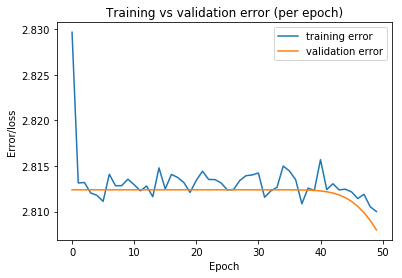

In [30]:
error = pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/val_error.pkl")
error.plot(title = "Training vs validation error (per epoch)")
plt.ylabel('Error/loss')
plt.xlabel('Epoch');
plt.show()

In [31]:
if val:
    print("Validation ...")
    init_op = tf.global_variables_initializer()
    session_conf = tf.ConfigProto(allow_soft_placement = allow_soft_placement, log_device_placement = log_device_placement)

    with tf.Session(config = session_conf) as sess:      
        new_saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_prefix))
        new_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
        test_err2 = np.array([])

        for users, items, rates in iter_test:
            pred_batch = sess.run(infer, feed_dict = {user_batch: users,
                                                    item_batch: items})
            pred_batch = clip(pred_batch)
            test_err2 = np.append(test_err2, np.power(pred_batch - rates, 2))
            print("Validation Error: ",np.sqrt(np.mean(test_err2)))
    print("Done !!!")
    sess.close()

Validation ...
INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/save/model
Validation Error:  2.8067385360692345
Done !!!


In [32]:
def create_df(ratings_df=readers.read_file(data_file, sep="::")):
    """
    Use to create a trained DataFrame,all missing values in user-item table
    is filled here using SVD trained model
    INPUTS :
        ratings_df : rating dataframe, store all users rating for respective movies

    OUTPUT:
        Filled rating dataframe where user is row and item is col
    """
    if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table.pkl"):
        df=pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table.pkl")
    else:
        df = ratings_df.pivot(index = 'user', columns ='item', values = 'rate').fillna(0)
        df.to_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table.pkl")
    
    df=df.T
    users=[]
    items=[]
    start = time.time()

    print("Start creating user-item dense table")
    total_movies=list(ratings_df.item.unique())
    for index in df.columns.tolist():
        #rated_movies=ratings_df[ratings_df['user']==index].drop(['st', 'user'], axis=1)
        rated_movie=[]
        rated_movie=list(ratings_df[ratings_df['user']==index].drop(['st', 'user'], axis=1)['item'].values)
        unseen_movies=[]
        unseen_movies=list(set(total_movies) - set(rated_movie))
        for movie in unseen_movies:
            users.append(index)
            items.append(movie)

    end = time.time()
    print(("Found in %.2f seconds" % (end-start)))
    del df
    rated_list = []

    init_op = tf.global_variables_initializer()
    session_conf = tf.ConfigProto(allow_soft_placement = allow_soft_placement, log_device_placement = log_device_placement)

    with tf.Session(config = session_conf) as sess:
        #sess.run(init_op)
        print("prediction started ...")
        new_saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_prefix))
        new_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
        test_err2 = np.array([])
        rated_list = sess.run(infer, feed_dict={user_batch: users, item_batch: items})
        rated_list = clip(rated_list)
        print("Done !!!")

    sess.close()
    df_dict={'user':users,'item':items,'rate':rated_list}
    df = ratings_df.drop(['st'],axis=1).append(pd.DataFrame(df_dict)).pivot(index = 'user', columns ='item', values = 'rate').fillna(0)
    df.to_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table_train.pkl")
    return df

In [33]:
create_df(ratings_df = readers.read_file(data_file, sep="::"))

Start creating user-item dense table
Found in 37.69 seconds
prediction started ...
INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/save/model
Done !!!


item,0,1,2,3,4,5,6,7,8,9,...,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951
user,,,,,,,,,,,,,,,,,,,,,
0,5.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.00000,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,4.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.00000,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,4.00000,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,5.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0


In [34]:
K = 5 # Number of clusters
MAX_ITERS = 1000 # Maximum number of iterations
TRAINED = False # Use TRAINED user vs item matrix

In [35]:
def bucket_mean(data, bucket_ids, num_buckets):
    total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
    count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
    return total / count

In [36]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # We perform the training on CPU

def k_mean_clustering(ratings_df, K = 5, MAX_ITERS = 1000,TRAINED = False):
    """
    Return movies alongwith there respective clusters
    INPUTS :
        ratings_df : rating dataframe, store all users rating for respective movies
        K          : number of clusters
        MAX_ITERS  : maximum number of recommendation
        TRAINED    : TRUE or FALSE, weather use trained user vs movie table or untrained
    OUTPUT:
        List of movies/items and list of clusters
    """
    if TRAINED:
        df = pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table_train.pkl")
    else:
        df = pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table.pkl")
    df = df.T

    start = time.time()
    N = df.shape[0]

    points = tf.Variable(df.as_matrix())
    cluster_assignments = tf.Variable(tf.zeros([N], dtype = tf.int64))

    # Silly initialization:  Use the first K points as the starting
    # centroids.  In the real world, do this better.
    centroids = tf.Variable(tf.slice(points.initialized_value(), [0,0], [K,df.shape[1]]))

    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, df.shape[1]])
    rep_points = tf.reshape(tf.tile(points, [1, K]), [N, K, df.shape[1]])
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), reduction_indices = 2)

    # Use argmin to select the lowest-distance point
    best_centroids = tf.argmin(sum_squares, 1)
    did_assignments_change = tf.reduce_any(tf.not_equal(best_centroids, cluster_assignments))

    means = bucket_mean(points, best_centroids, K)

    # Do not write to the assigned clusters variable until after
    # computing whether the assignments have changed - hence with_dependencies
    with tf.control_dependencies([did_assignments_change]):
        do_updates = tf.group(centroids.assign(means),cluster_assignments.assign(best_centroids))

    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)

    changed = True
    iters = 0

    while changed and iters < MAX_ITERS:
        iters += 1
        [changed, _] = sess.run([did_assignments_change, do_updates])

    [centers, assignments] = sess.run([centroids, cluster_assignments])
    end = time.time()
    print (("Found in %.2f seconds" % (end-start)), iters, "iterations")
    cluster_df=pd.DataFrame({'movies':df.index.values,'clusters':assignments})
    cluster_df.to_csv("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/clusters.csv",index = True)
    return assignments,df.index.values

In [37]:
ratings_df = readers.read_file(data_file, sep = "::")
clusters, movies = k_mean_clustering(ratings_df,K = K,MAX_ITERS = MAX_ITERS,TRAINED = TRAINED)

user_item = pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table.pkl")
cluster = pd.read_csv("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/clusters.csv", index_col = False)

user_item = user_item.T

Found in 39.51 seconds 29 iterations


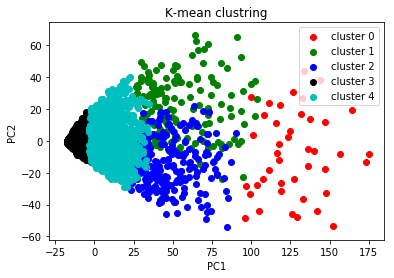

In [38]:
pcs = PCA(n_components=2, svd_solver='full')
cluster['x']=pcs.fit_transform(user_item)[:,0]
cluster['y']=pcs.fit_transform(user_item)[:,1]

fig = plt.figure()
ax = plt.subplot(111)


ax.scatter(cluster[cluster['clusters']==0]['x'].values,cluster[cluster['clusters']==0]['y'].values,color="r", label='cluster 0')
ax.scatter(cluster[cluster['clusters']==1]['x'].values,cluster[cluster['clusters']==1]['y'].values,color="g", label='cluster 1')
ax.scatter(cluster[cluster['clusters']==2]['x'].values,cluster[cluster['clusters']==2]['y'].values,color="b", label='cluster 2')
ax.scatter(cluster[cluster['clusters']==3]['x'].values,cluster[cluster['clusters']==3]['y'].values,color="k", label='cluster 3')
ax.scatter(cluster[cluster['clusters']==4]['x'].values,cluster[cluster['clusters']==4]['y'].values,color="c", label='cluster 4')

ax.legend()
plt.title("K-mean clustring")
plt.ylabel('PC2')
plt.xlabel('PC1');
plt.show()

In [39]:
cluster_df=pd.DataFrame({'movies':movies,'clusters':clusters})
cluster_df.head(10)

print("Predicted cluster || Movie ID")
print(cluster_df[cluster_df['movies']==1721])

print("Predicted cluster || Movie ID")
print(cluster_df[cluster_df['movies']==1369])

print("Predicted cluster || Movie ID")
print(cluster_df[cluster_df['movies']==164])

print("Predicted cluster || Movie ID")
print(cluster_df[cluster_df['movies']==3081])

print("Predicted cluster || Movie ID")
print(cluster_df[cluster_df['movies']==732])

print("Predicted cluster || Movie ID")
print(cluster_df[cluster_df['movies']==348])

print("Predicted cluster || Movie ID")
print(cluster_df[cluster_df['movies']==647])

Predicted cluster || Movie ID
      movies  clusters
1575    1721         2
Predicted cluster || Movie ID
      movies  clusters
1271    1369         2
Predicted cluster || Movie ID
     movies  clusters
159     164         2
Predicted cluster || Movie ID
      movies  clusters
2866    3081         2
Predicted cluster || Movie ID
     movies  clusters
699     732         2
Predicted cluster || Movie ID
     movies  clusters
339     348         2
Predicted cluster || Movie ID
     movies  clusters
627     647         2


In [40]:
user = 1696 # User (default: 1696)
item = 3113, # Movie (default: 3113)

In [41]:
def clip(x):
    return np.clip(x, 1.0, 5.0) # rating 1 to 5

In [42]:
user = np.array([user])
item = np.array([item])

In [43]:
def prediction(users=user,items=item,allow_soft_placement=allow_soft_placement,log_device_placement=log_device_placement,checkpoint_dir=checkpoint_dir):
    # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
    rating_prediction=[]
    checkpoint_prefix = os.path.join(checkpoint_dir, "model")

    graph = tf.Graph()
    with graph.as_default():
        session_conf = tf.ConfigProto(allow_soft_placement=allow_soft_placement,log_device_placement=log_device_placement)
        with tf.Session(config = session_conf) as sess:
            new_saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_prefix))
            new_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))

            # Get the placeholders from the graph by name
            user_batch = graph.get_operation_by_name("id_user").outputs[0]
            item_batch = graph.get_operation_by_name("id_item").outputs[0]

            # Tensors we want to evaluate
            predictions = graph.get_operation_by_name("svd_inference").outputs[0]
            pred = sess.run(predictions, feed_dict={user_batch: users, item_batch: items})
            pred = clip(pred)
            #print(pred)
        sess.close()
    return  pred

In [44]:
def user_rating(users,movies):
    """
    Returns user rating for respective user
    INPUTS :
        users      : list of numbers or number, list of user ids or just user id
        movies : list of numbers or number, list of movie ids or just movie id
    OUTPUT:
        list of predicted movies
    """
    if type(users) is not list:
        users=np.array([users])
    if type(movies) is not list:
        movies=np.array([movies])
    return prediction(users, movies)

In [45]:
print(user_rating(0, 1198))
print(user_rating(0, 660)) 

INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/save/model
[1.]
INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/save/model
[1.]


In [46]:
def top_k_movies(users,ratings_df,k):
    """
    Returns top k movies for respective user
    INPUTS :
        users      : list of numbers or number , list of user ids
        ratings_df : rating dataframe, store all users rating for respective movies
        k          : natural number
    OUTPUT:
        Dictionary conatining user id as key and list of top k movies for that user as value
    """
    # Extract unseen movies
    dicts={}
    if type(users) is not list:
        users=[users]
    for user in users:
        rated_movies=ratings_df[ratings_df['user']==user].drop(['st', 'user'], axis=1)
        rated_movie=list(rated_movies['item'].values)
        total_movies=list(ratings_df.item.unique())
        unseen_movies=list(set(total_movies) - set(rated_movie))
        rated_list = []
        rated_list=prediction(np.full(len(unseen_movies),user),np.array(unseen_movies))
        useen_movies_df=pd.DataFrame({'item': unseen_movies,'rate':rated_list})
        top_k=list(useen_movies_df.sort_values(['rate','item'], ascending=[0, 0])['item'].head(k).values)
        dicts.update({user:top_k})
    result=pd.DataFrame(dicts)
    result.to_csv("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_top_k.csv")
    return dicts

# Making prediction
# Top K movie recommendation for User
top_k_movies([768], ratings_df, 10)
top_k_movies(1198, ratings_df, 10)

INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/save/model
INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/save/model


{1198: [3951, 3950, 3949, 3948, 3947, 3946, 3945, 3944, 3943, 3942]}

In [47]:
def item_item_correlation(df,TRAINED):
    if TRAINED:
        if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/item_item_corr_train.pkl"):
            df_corr=pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/item_item_corr_train.pkl")
        else:
            df_corr=df.corr()
            df_corr.to_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/item_item_corr_train.pkl")
    else:
        if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/item_item_corr.pkl"):
            df_corr=pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/item_item_corr.pkl")
        else:
            df_corr=df.corr()
            df_corr.to_pickle("item_item_corr.pkl")
    return df_corr

def top_k_similar_items(movies,ratings_df,k,TRAINED=False):
    """
    Returns k similar movies for respective movie
    INPUTS :
        movies : list of numbers or number, list of movie ids
        ratings_df : rating dataframe, store all users rating for respective movies
        k          : natural number
        TRAINED    : TRUE or FALSE, weather use trained user vs movie table or untrained
    OUTPUT:
        list of k similar movies for respected movie
    """
    if TRAINED:
        df=pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table_train.pkl")
    else:
        df=pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table.pkl")

    corr_matrix=item_item_correlation(df,TRAINED)
    if type(movies) is not list:
        return corr_matrix[movies].sort_values(ascending=False).drop(movies).index.values[0:k]
    else:
        dict={}
        for movie in movies:
            dict.update({movie:corr_matrix[movie].sort_values(ascending=False).drop(movie).index.values[0:k]})
        pd.DataFrame(dict).to_csv("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/movie_top_k.csv")
        return dict
    
# Sample prediction
top_k_similar_items(9, ratings_df=ratings_df, k= 10, TRAINED=False)

array([1721, 1369,  164, 3081,  732,  348,  647, 2005,  379, 3255],
      dtype=int64)

In [ ]:
def user_user_pearson_corr(ratings_df,TRAINED):
    if TRAINED:
        if os.path.isfile("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_user_corr_train.pkl"):
            df_corr=pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_user_corr_train.pkl")
        else:
            df =pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table_train.pkl")
            df=df.T
            df_corr=df.corr()
            df_corr.to_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_user_corr_train.pkl")
    else:
        if os.path.isfile("model/user_user_corr.pkl"):
            df_corr=pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_user_corr.pkl")
        else:
            df = pd.read_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_item_table.pkl")
            df=df.T
            df_corr=df.corr()
            df_corr.to_pickle("C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 10/model/user_user_corr.pkl")
    return df_corr

def user_similarity(user_1,user_2,ratings_df,TRAINED=False):
    """
    Return the similarity between two users
    INPUTS :
        user_1,user_2 : number, respective user ids
        ratings_df : rating dataframe, store all users rating for respective movies
        TRAINED    : TRUE or FALSE, weather use trained user vs movie table or untrained
    OUTPUT:
        Pearson cofficient between users [value in between -1 to 1]
    """
    corr_matrix=user_user_pearson_corr(ratings_df,TRAINED)

    return corr_matrix[user_1][user_2]

# Pearson Correlation between User-User. When you run this User Similarity function, on first run it will take time to give output but after that it's response is in real-time.
user_similarity(1, 345, ratings_df)